<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>


In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// needed to generate the Table of contents 
// taken from github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

In [2]:
#To work with Atom and Jupyter at the same time

%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import gridspec #gridspec allows me to make a subplot with different aspect ratio
#from IPython.display import Image #used to display images saved to disk

sns.set() #setting default Seaborn plot style

In [4]:
import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [5]:
from sklearn.cluster import KMeans

import numpy as np


In [6]:
from IPython.display import Image #used to display images saved to disk

In [7]:
filename = 'train.csv' 
#try also 'data/test.csv' and 'data/RUL.csv' for similar results
file_path = '../data/'+filename
df = pd.read_csv(file_path)

df_test = pd.read_csv('../data/test.csv')
df_RUL = pd.read_csv('../data/RUL.csv')

In [8]:
df.head(5)

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,dataset
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,FD003
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,FD003
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,FD003
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,FD003
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,FD003


In [9]:
df.shape

(160359, 27)

# Exploratory Data Analysis

## Explore Data Relationships


In [10]:
# for convenience, identify the sensor and operational setting columns
s_columns = [col for col in df.columns if col.startswith("s")]
op_setting_columns = [col for col in df.columns if col.startswith("op_setting")]
data_cols = op_setting_columns + s_columns

Generate Pairplot of Operating columns

In [11]:
# # pair plot takes way too long there are too many variables
# fig = plt.figure()
# sns.pairplot(df[s_columns])
# plt.savefig('../figures/pairplot.png')

### Automatic report with pandas-profiling

In [12]:
profile_report = df.profile_report(html={'style': {'full_width': True}},progress_bar=True)
profile_report.to_file("figures/data_profiling_report.html")
profile_report

FileNotFoundError: [Errno 2] No such file or directory: 'figures/data_profiling_report.html'

**Takeaways :** Many sensor readings are fairly constant and probably will not be good predictors of the Remaning Usable Life.

### Operating Conditions

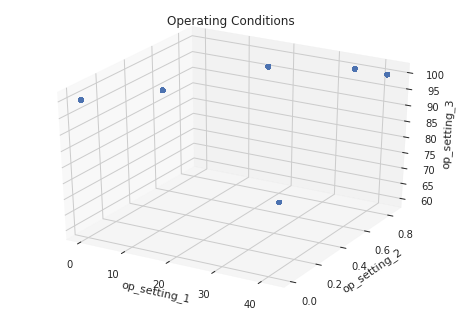

In [13]:
sns.set_style("whitegrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[op_setting_columns[0]],df[op_setting_columns[1]],df[op_setting_columns[2]])
ax.set_xlabel(op_setting_columns[0])
ax.set_ylabel(op_setting_columns[1])
ax.set_zlabel(op_setting_columns[2])
ax.set_title('Operating Conditions')
plt.show()

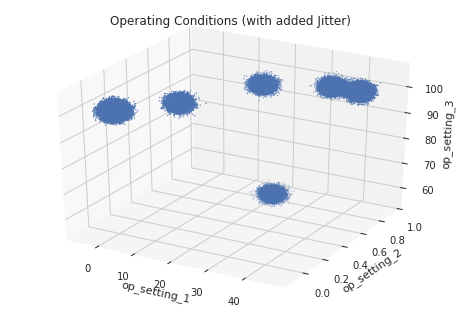

In [14]:
def rand_jitter(arr):
    stdev = .03*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


sns.set_style("whitegrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rand_jitter(df[op_setting_columns[0]].values),rand_jitter(df[op_setting_columns[1]].values),rand_jitter(df[op_setting_columns[2]].values), s=1)
ax.set_xlabel(op_setting_columns[0])
ax.set_ylabel(op_setting_columns[1])
ax.set_zlabel(op_setting_columns[2])
ax.set_title('Operating Conditions (with added Jitter)')
plt.show()

**Takeaways :** We observe that the Operating condistions are clustered in 6 operating regimes.

### Sensor Readings

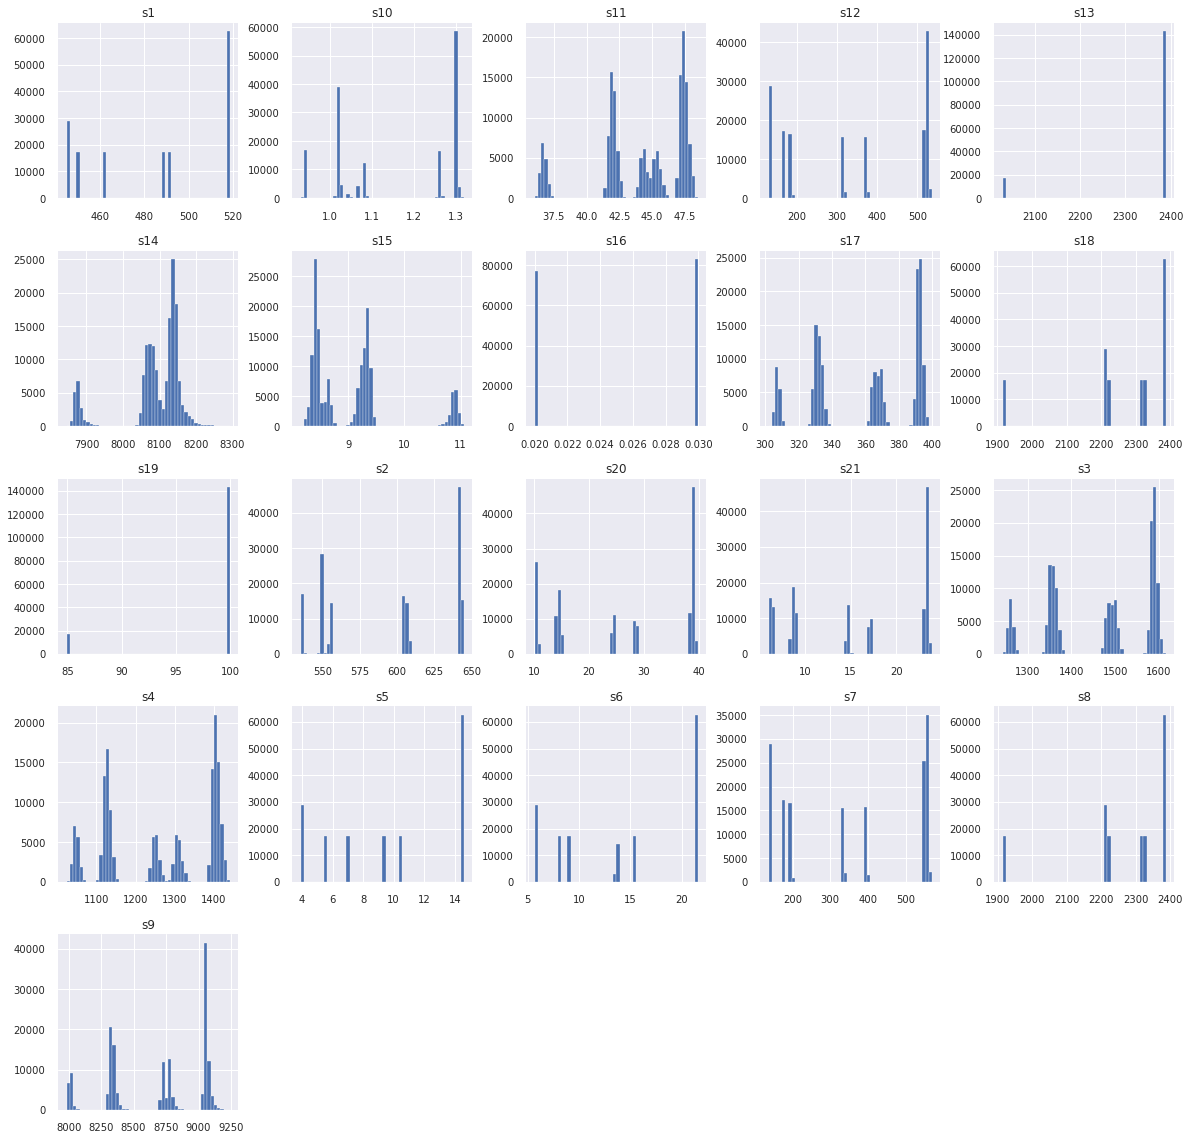

In [15]:
#histograms for each sensor column in df
sns.set_style("darkgrid")

hist = df[s_columns].hist(bins=50, figsize =(20,20))


**Takeaways:** There are several sensor readings that have only a handful of values. Like s13, s16, s19. Sensors with constant values will unlikely be a good predictor of the engine degradation.

## Identification and creation of Features

### Operating Regime

As we observed we have 6 operating regimes. Let's cluster the data and create a new variable *op_regime* which can replace the 3 op_settings

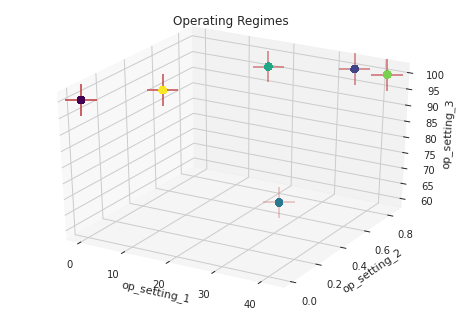

In [16]:
# This code will fit the k-means algorithm with our k parameter set to 6, and plot the results.
op_regimes = df[op_setting_columns].values
kmeans6 = KMeans(n_clusters=6)
y_kmeans6 = kmeans6.fit_predict(op_regimes)

centers = kmeans6.cluster_centers_

sns.set_style("whitegrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(op_regimes[:, 0], op_regimes[:, 1], op_regimes[:, 2], c=y_kmeans6, s=50, cmap='viridis', alpha=0.5)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], marker='+', c='r', s=1000)

ax.set_xlabel(op_setting_columns[0])
ax.set_ylabel(op_setting_columns[1])
ax.set_zlabel(op_setting_columns[2])
ax.set_title('Operating Regimes')
plt.savefig('../figures/Op_regime_clustering.png')
plt.show()

In [17]:
# Adding a op_regime column to the dataframe
df['op_regime'] = y_kmeans6+1

In [18]:
df.head()

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,dataset,op_regime
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,FD003,1
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,FD003,1
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,FD003,1
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,FD003,1
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,FD003,1


**Questions :** Do mulitple operating regime occur in each dataset?

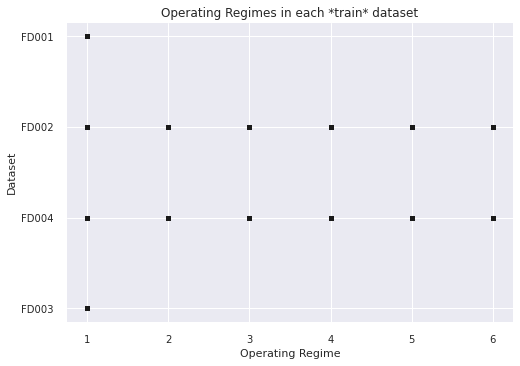

In [19]:
#plot distribution of operating regimes vs dataset
sns.set_style("darkgrid")
plt.scatter(df['op_regime'],df['dataset'],s=20,c='k')
plt.title('Operating Regimes in each *train* dataset')
plt.xlabel('Operating Regime')
plt.ylabel('Dataset')
plt.savefig('../figures/Op_regime_vs_dataset.png')
plt.show()

In [20]:
#use same model to add op_regime column to test data
op_regimes_test = df_test[op_setting_columns].values
df_test['op_regime'] = kmeans6.predict(op_regimes_test)+1

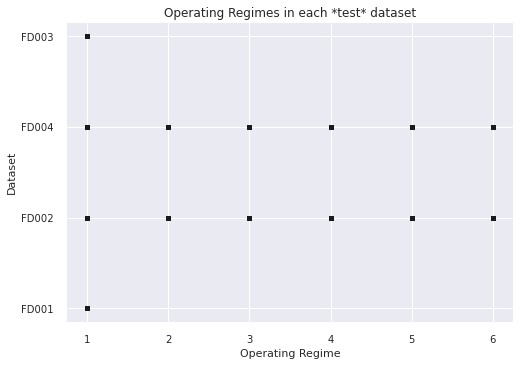

In [21]:
#plot distribution of operating regimes vs dataset in the test data
sns.set_style("darkgrid")
plt.scatter(df_test['op_regime'],df_test['dataset'],s=20,c='k')
plt.title('Operating Regimes in each *test* dataset')
plt.xlabel('Operating Regime')
plt.ylabel('Dataset')
plt.savefig('../figures/Op_regime_vs_dataset_test_data.png')
plt.show()

**Takeaway :** Dataset FD001 and FD003 feature data only for Operating regime #1.

### Remaining Usable Life (RUL)

Let's add a RUL column to the data. Translating the data so that the last cycle time for each time-series is 0.

In [22]:
# calculate maximum lifetime for each time-series
lifetimes = df.groupby(['dataset', 'unit_number'])['cycle_time'].max()
lifetimes.head()

dataset  unit_number
FD001    1              192
         2              287
         3              179
         4              189
         5              269
Name: cycle_time, dtype: int64

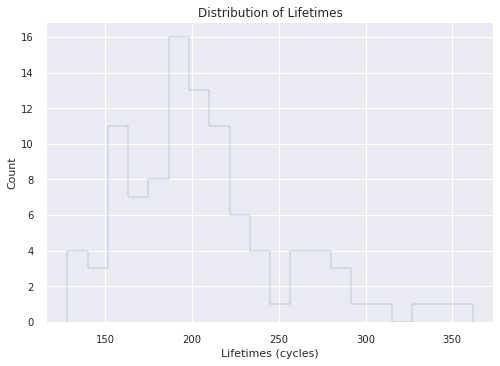

In [23]:
_ = plt.hist(lifetimes['FD001'],
             bins=20,
             density=False,
             histtype='step')

_ = plt.title('Distribution of Lifetimes')
_ = plt.xlabel('Lifetimes (cycles)')
_ = plt.ylabel('Count')

In [24]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

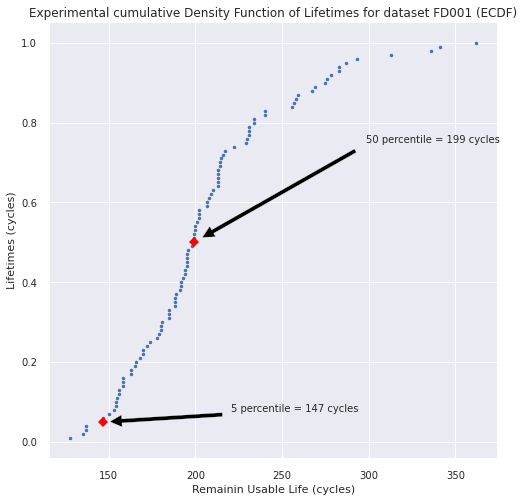

In [25]:
x_life, y_life = ecdf(lifetimes['FD001'])
percentiles =  np.array([5,50])
percentiles_lifetimes = np.percentile(lifetimes['FD001'], percentiles)

fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
# Generate plot
ax.plot(x_life, y_life,marker='.',linestyle='none')
ax.plot(percentiles_lifetimes, percentiles/100, marker='D', color='red',
         linestyle='none')
# Label the axes
# Label axes
ax.annotate('5 percentile = {} cycles'.format(round(percentiles_lifetimes[0])), 
            xy=(percentiles_lifetimes[0], percentiles[0]/100), 
            xytext=(1.5*percentiles_lifetimes[0], 1.5*percentiles[0]/100),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('50 percentile = {} cycles'.format(round(percentiles_lifetimes[1])), 
            xy=(percentiles_lifetimes[1], percentiles[1]/100), 
            xytext=(1.5*percentiles_lifetimes[1], 1.5*percentiles[1]/100),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_title('Experimental cumulative Density Function of Lifetimes for dataset FD001 (ECDF)')
ax.set_xlabel('Remainin Usable Life (cycles)')
ax.set_ylabel('Lifetimes (cycles)')

fig.savefig('../figures/lifetimes_FD001_ecdf.png')
plt.show()


In [26]:
# adding a progress bar to this operation. We will use df.progress_apply instead of df.apply
from tqdm.auto import tqdm
tqdm.pandas()

# calculate the Reamining Usable Life for each entry
# WARNING!! : This can take a minute or two
df['RUL'] = df.progress_apply( lambda row : row["cycle_time"]-lifetimes.loc[row["dataset"]].loc[row["unit_number"]] , axis=1)

/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [27]:
df.head()

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,dataset,op_regime,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8.4246,0.03,391,2388,100.0,39.11,23.3537,FD003,1,-258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8.4403,0.03,392,2388,100.0,38.99,23.4491,FD003,1,-257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8.3901,0.03,391,2388,100.0,38.85,23.3669,FD003,1,-256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8.3878,0.03,392,2388,100.0,38.96,23.2951,FD003,1,-255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8.3869,0.03,392,2388,100.0,39.14,23.4583,FD003,1,-254


## Merging Test and RUL
Let's do the same operation on the Test dataset, by taking into considertion the labels listed in RUL.csv

In [28]:
# df_test = pd.read_csv('data/test.csv')
# df_RUL = pd.read_csv('data/RUL.csv')
print(df_test.groupby(['unit_number', 'dataset']).sum().shape)
print(df_RUL.shape)

(707, 26)
(707, 3)


In [29]:
df_test.head(3)

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,dataset,op_regime
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,FD001,1
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,FD001,1
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,FD001,1


In [30]:
df_RUL[df_RUL['unit_number']==3]

,RUL,unit_number,dataset
2,106,3,FD002
261,27,3,FD003
361,69,3,FD001
461,107,3,FD004


In [31]:
partial_lifetimes = df_test.groupby(['dataset', 'unit_number'])['cycle_time'].max()
rul = df_RUL.groupby(['dataset', 'unit_number'])['RUL'].max()
df_test['RUL'] = df_test.progress_apply( lambda row : row["cycle_time"]-partial_lifetimes.loc[row["dataset"]].loc[row["unit_number"]]-rul.loc[row["dataset"]].loc[row["unit_number"]] , axis=1)


In [32]:
df_test.head()

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,dataset,op_regime,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,FD001,1,-142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,FD001,1,-141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,FD001,1,-140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,FD001,1,-139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,FD001,1,-138


### Sensor Selection

Let's look at what the sensor traces look like in each dataset.

FileNotFoundError: [Errno 2] No such file or directory: 'figures/FD003_sensor_traces.png'

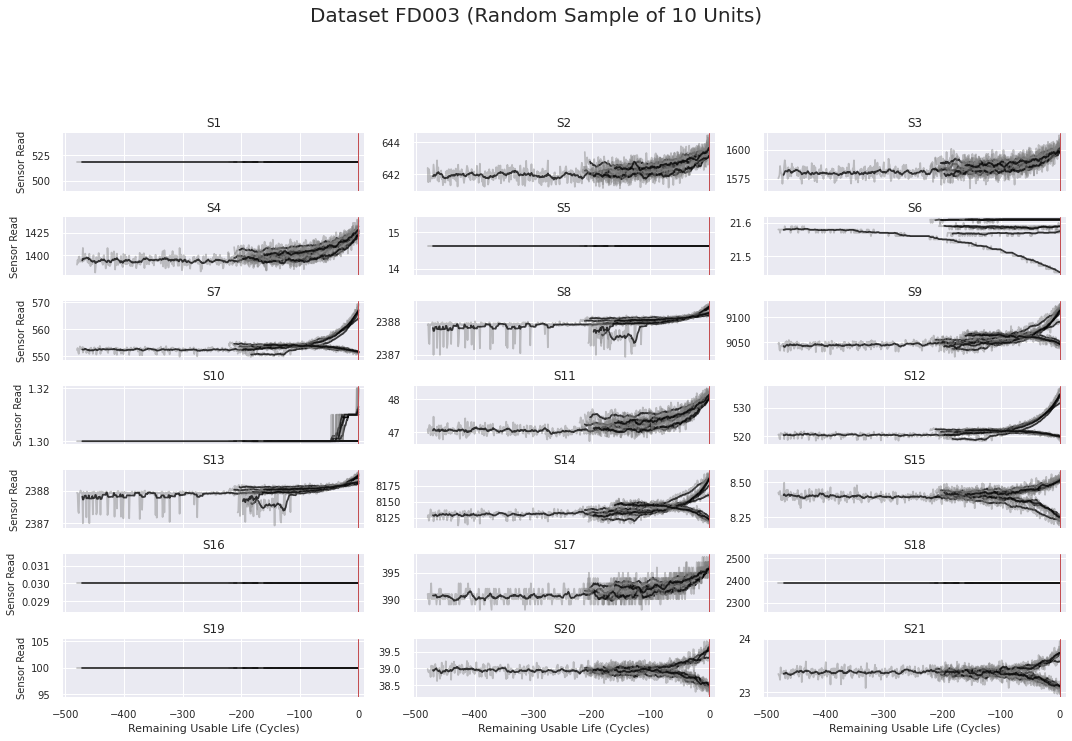

In [33]:
dataset_list = df['dataset'].unique()

for dataset_choice in tqdm(dataset_list, desc='Generating one image per dataset' ) :
    # randomly select 10 units from dataset 1 to plot
    all_units = df[df['dataset'] == dataset_choice]['unit_number'].unique()
    units_to_plot = np.random.choice(all_units, size=10, replace=False)
    # get the data for these units
    plot_data = df[(df['dataset'] == dataset_choice) & (df['unit_number'].isin(units_to_plot))].copy()
    # plot the sensor traces (overlaid)
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)
    for index, ax in tqdm(enumerate(axes.ravel()), total=len(axes.ravel()), desc='Generating one sensor sub-plot', leave=False):
        s_col = s_columns[index]
        # use the same subset of data as above
        for unit_id, group in tqdm(plot_data.groupby('unit_number'), desc='Overlaying sensor traces', leave=False):
            # plot the raw sensor trace, using RUL on the time axis
            (group
                 .plot(x='RUL', y=s_col, alpha=0.45, ax=ax, color='gray', legend=False));
            # overlay the 10-cycle rolling mean sensor trace for visual clarity
            (group
                 .rolling(window=10, on='RUL')
                 .mean()
                 .plot(x='RUL', y=s_col, alpha=.75, ax=ax, color='black', legend=False));
        # label formatting
        if index % 3 == 0:
            ax.set_ylabel("Sensor Read", size=10);
        else:
            ax.set_ylabel("");
        ax.set_title(s_col.title())
        ax.set_xlabel("Remaining Usable Life (Cycles)")
        # add a vertical red line to signal common time of failure
        ax.axvline(x=0, color='r', linewidth=1)
        # extend the x-axis to compensate 
        ax.set_xlim([None, 10])
    image_title = "Dataset "+dataset_choice+" (Random Sample of 10 Units)"
    fig.suptitle(image_title, size=20, y=1.025)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig_path = 'figures/'+dataset_choice+"_sensor_traces.png"
    fig.savefig(fig_path) 
    plt.close()


In [ ]:
Image(filename='figures/FD001_sensor_traces.png') 

In [ ]:
Image(filename='figures/FD002_sensor_traces.png') 

In [ ]:
Image(filename='figures/FD003_sensor_traces.png') 

In [ ]:
Image(filename='figures/FD004_sensor_traces.png') 

**Takeaways :** Each dataset has distinctively different sensor profiles. In FD003 and FD004 are difficult to interpret, most sensors do not exhibit any obvious trend that might be a sign of degradation. In FD001 and FD002 we can weed out several sensors where the value is constant. In FD001 for example we could remove from the models sensors s1, s5, s10, s16, s18, s19 as their value does not change at all from cycle to cycle.



## EDA Conclusions



To begin with we will concentrate our efforts on modelling operating regime #1, thus we will only use dataset FD001 to begin with. Based on the findings we can expand and attempt to work with the other datasets as well. 

In [ ]:
train_op_regime2_FD001 = df[df['dataset'] == 'FD001'].copy()
train_op_regime2_FD001.to_csv('data/train_op_regime2_FD001.csv', index=False)

In [ ]:
df_test.head()

In [ ]:
#df_test = pd.read_csv('data/test.csv')
test_op_regime2_FD001 = df_test[df_test['dataset'] == 'FD001'].copy()
test_op_regime2_FD001.to_csv('data/test_op_regime2_FD001.csv', index=False)